In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline 
import csv
import datetime
import psycopg2
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from datetime import datetime
import json
path="/Users/pearlchitranshi/Documents"
os.chdir(path)

# import import_ipynb
# from price_trends import df as price_trends
import math
conn = psycopg2.connect(user = 'datateam_redshift',
                                    password = 'Redshift@123',
                                    host = 'redshift-prod.amber-data.com',
                                    port = 5439,
                                    database = 'amberdb')

In [10]:
inventories=pd.read_csv('inventories.csv')

/var/folders/7z/3_43hmyd44v7pjv450ysr_x80000gn/T/ipykernel_96125/3547403749.py:1: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  inventories=pd.read_csv('inventories.csv')


In [15]:
inventories.columns

Index(['Unnamed: 0', 'id', 'source', 'source_link', 'inventory_name',
       'created_at', 'ancestor_id', 'region_type', 'currency', 'paid_duration',
       'pricing', 'max_sp', 'min_sp', 'payment_duration',
       'max_available_price', 'min_available_price', 'owner_email',
       'owner_phone', 'lease_available_from', 'lease_available_to',
       'lease_duration', 'accomadation_type', 'bedroom_count_source1',
       'bedroom_count_source2', 'bathroom_count', 'area_unit', 'area_number',
       'latitude', 'longitude', 'country', 'state', 'district_name', 'wifi',
       'pets_allowed', 'pool', 'public_transportation', 'air_condition',
       'table_chair', 'dishwasher', 'property_id', 'source.1',
       'property_source_link', 'property_inventory_name',
       'property_region_type', 'property_currency', 'property_paid_duration',
       'property_price', 'property_max_sp', 'property_min_sp',
       'property_payment_duration', 'property_max_available_price',
       'property_min_availa

# Cleanup

In [11]:

dummies = inventories['property_accomadation_type'].str.get_dummies(sep=',')
inventories=pd.concat([inventories,dummies],axis=1)
inventories.drop('property_accomadation_type',axis=1,inplace=True)
inventories.rename(columns={'property_pricing':'pricing'},inplace=True)
columns_to_convert = ['pricing','max_sp', 'min_sp', 'max_available_price', 'min_available_price']
inventories[columns_to_convert] = inventories[columns_to_convert].apply(pd.to_numeric, errors='coerce')
inventories[columns_to_convert] = inventories[columns_to_convert].astype(float)
inventories['created_at'] = pd.to_datetime(inventories['created_at'])
inventories['month_of_date']= inventories['created_at'].dt.month
inventories['year_of_date']= inventories['created_at'].dt.year

#Converting Duration to uniform
conversion_factors = {
    'weekly': 4,
    'monthly': 1
}
unit_column = 'paid_duration'
inventories['pricing'] = inventories.apply(lambda row: row['pricing'] * conversion_factors.get(row[unit_column], 1), axis=1)

conversion_factors_area = {
    'sqft': .092903,
    'sqm': 1
}
unit_column = 'area_unit'  # Replace 'area_unit' with the actual name of your unit column
inventories['property_size'] = inventories.apply(lambda row: row['area_number'] * conversion_factors_area.get(row[unit_column], 1), axis=1)


# EDA

([<matplotlib.patches.Wedge at 0x7fad90364490>,
 [Text(-1.0371142010556729, 0.36659805505301535, 'Greater London'),
  Text(0.9385217331124576, -0.5737394499906635, 'West Midlands'),
  Text(1.0328157111996406, -0.37853891041632814, 'West Yorkshire'),
  Text(1.0718288798278541, -0.24735167750991266, 'Greater Manchester'),
  Text(1.092139807153928, -0.13126553862221718, 'Brisbane City'),
  Text(1.099319052574527, -0.03869910395144154, 'Cook County')],
 [Text(-0.565698655121276, 0.19996257548346288, '89.18%'),
  Text(0.5119209453340677, -0.31294879090399824, '4.16%'),
  Text(0.5633540242907129, -0.20647576931799713, '2.12%'),
  Text(0.5846339344515566, -0.1349190968235887, '1.84%'),
  Text(0.5957126220839607, -0.07159938470302754, '1.57%'),
  Text(0.5996285741315601, -0.021108602155331748, '1.12%')])

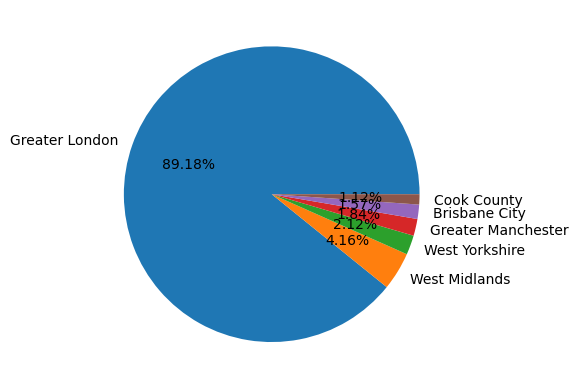

In [12]:
state_name=inventories.property_district_name.value_counts().index
state_val=inventories.property_district_name.value_counts().values
plt.pie(state_val[:6],labels=state_name[:6],autopct='%1.2f%%')

<function seaborn.utils.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)>

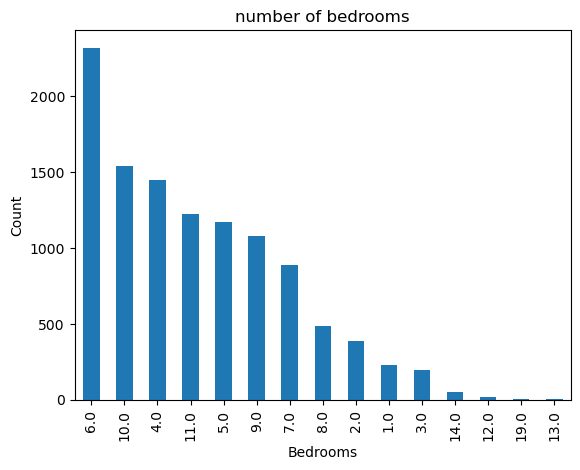

In [13]:
inventories['bedroom_count_source2'].value_counts().plot(kind='bar')
plt.title('number of bedrooms')
plt.xlabel('Bedrooms')
plt.ylabel('Count')
sns.despine

Text(0.5, 1.0, 'Price Vs Area')

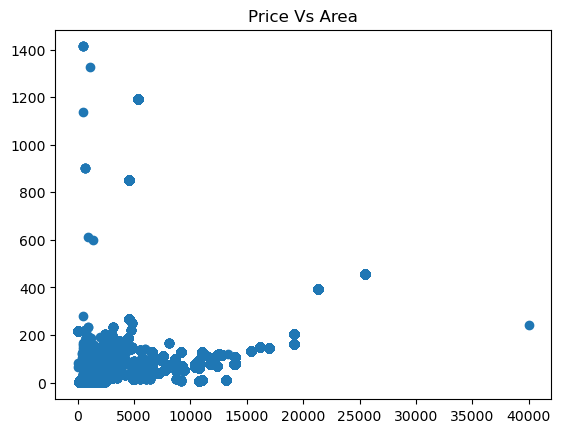

In [14]:
#price according to living area 
plt.scatter(inventories.pricing,inventories.property_size)
plt.title("Price Vs Area")

Text(0.5, 1.0, 'Price Vs Area')

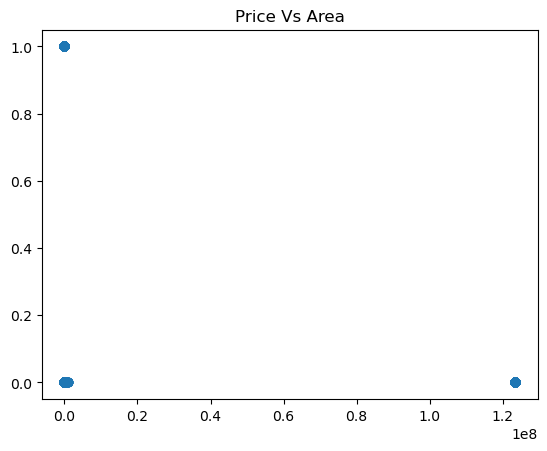

In [18]:
#price according to ammeneties
plt.scatter(inventories.pricing,inventories.wifi)
plt.title("Price Vs Area")

## Futher Cleanup on Specific geography level

In [20]:
inventories_london=inventories[inventories['property_district_name']=='Greater London']

In [ ]:
#Null Values identification
[features for features in inventories.columns if inventories[features].isnull().sum()>0]

In [21]:
#Replacing and filling bedroom counts
inventories_london['bedroom_count'] = inventories_london['bedroom_count_source2'].fillna(inventories_london['bedroom_count_source1'])
inventories_london.drop(['bedroom_count_source1', 'bedroom_count_source2'], axis=1, inplace=True)
pets_allowed_values = (inventories_london['pets_allowed'] == 0) & (inventories_london['property_pets_allowed'] == 1)
inventories_london.loc[pets_allowed_values,'pets_allowed']=1
wifi_values = (inventories_london['wifi'] == 0) & (inventories_london['property_wifi'] == 1)
inventories_london.loc[wifi_values,'wifi']=1
transportation_value = (inventories_london['public_transportation'] == 0) & (inventories_london['property_public_transportation'] == 1)
inventories_london.loc[transportation_value,'public_transportation']=1
ac_value = (inventories_london['air_condition'] == 0) & (inventories_london['property_air_condition'] == 1)
inventories_london.loc[ac_value,'air_condition']=1
table_chair_value = (inventories_london['table_chair'] == 0) & (inventories_london['property_table_chair'] == 1)
inventories_london.loc[table_chair_value,'table_chair']=1
dishwasher_value = (inventories_london['dishwasher'] == 0) & (inventories_london['property_dishwasher'] == 1)
inventories_london.loc[dishwasher_value,'dishwasher']=1
pool_value = (inventories_london['pool'] == 0) & (inventories_london['property_pool'] == 1)
inventories_london.loc[pool_value,'pool']=1

columns_to_fill_price = ['max_sp', 'min_sp', 'property_max_sp', 'property_min_sp','property_max_available_price','property_min_available_price']
for column in columns_to_fill_price:
    inventories_london['pricing'].fillna(inventories_london[column], inplace=True)

columns_to_fill_room = ['property_bedroom_count_source1', 'property_bedroom_count_source2']
for column in columns_to_fill_room:
    inventories_london['bedroom_count'].fillna(inventories_london[column], inplace=True)    
inventories_london['bedroom_count'].fillna(inventories_london['bedroom_count'].mean(),inplace=True)
inventories_london['bathroom_count'].fillna(inventories_london['property_bathroom_count'],inplace=True)                                                          
inventories_london['bathroom_count'].fillna(inventories_london['bathroom_count'].median(),inplace=True)
inventories_london['area_number'].fillna(inventories_london['property_area_number'],inplace=True)
inventories_london['area_number'].fillna(inventories_london['area_number'].mean(),inplace=True)
inventories_london['latitude'].fillna(inventories_london['latitude'].median(),inplace=True)
inventories_london['longitude'].fillna(inventories_london['longitude'].median(),inplace=True)
inventories_london['uni_latitude'].fillna(inventories_london['uni_latitude'].median(),inplace=True)
inventories_london['uni_longitude'].fillna(inventories_london['uni_longitude'].median(),inplace=True)
inventories_london['property_lease_duration'].fillna(inventories_london['property_lease_duration'].mean(),inplace=True)
inventories_london['pricing']=inventories_london['pricing'].astype(float)


/var/folders/7z/3_43hmyd44v7pjv450ysr_x80000gn/T/ipykernel_96125/2515671476.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inventories_london['bedroom_count'] = inventories_london['bedroom_count_source2'].fillna(inventories_london['bedroom_count_source1'])
/var/folders/7z/3_43hmyd44v7pjv450ysr_x80000gn/T/ipykernel_96125/2515671476.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inventories_london.drop(['bedroom_count_source1', 'bedroom_count_source2'], axis=1, inplace=True)
/var/folders/7z/3_43hmyd44v7pjv450ysr_x80000gn/T/ipykernel_96125/2515671476.py:21

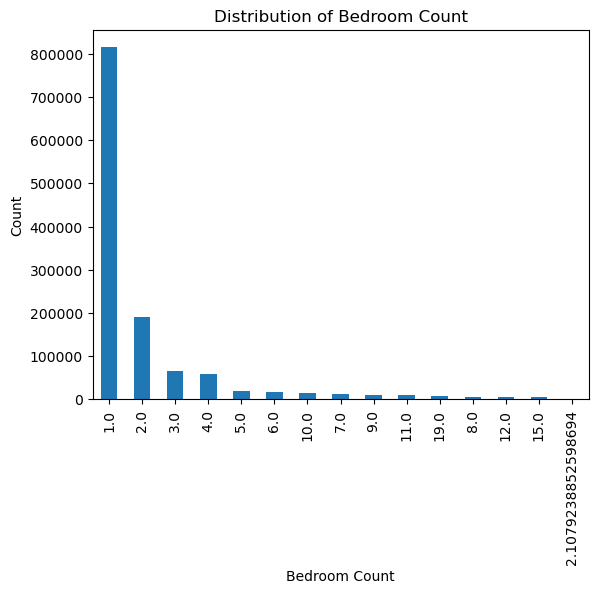

In [23]:
# Distribution visualization - Bar plot
inventories_london['bedroom_count'].value_counts().plot.bar()
plt.xlabel('Bedroom Count')
plt.ylabel('Count')
plt.title('Distribution of Bedroom Count')
plt.show()

/var/folders/7z/3_43hmyd44v7pjv450ysr_x80000gn/T/ipykernel_96125/3126573732.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inventories_london['created_at'] = pd.to_datetime(inventories_london['created_at'])


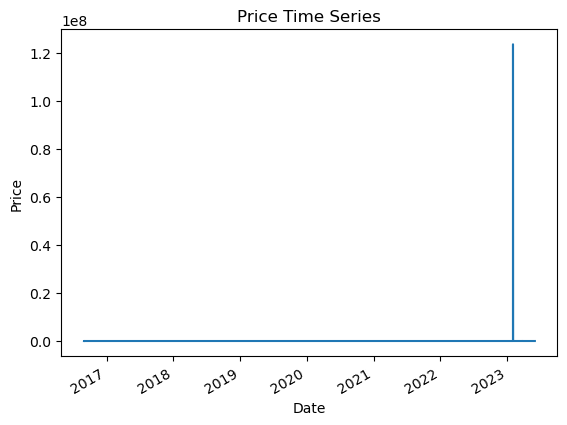

In [24]:
# Time series analysis
inventories_london['created_at'] = pd.to_datetime(inventories_london['created_at'])
inventories_london.set_index('created_at', inplace=True)
price_time_series = inventories_london['pricing']
price_time_series.plot()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price Time Series')
plt.show()

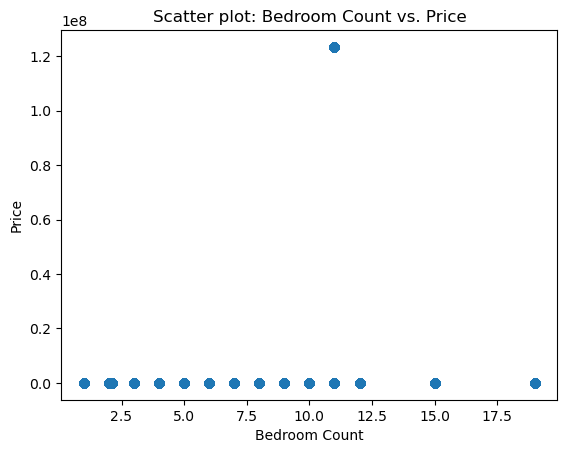

In [25]:
# Compare variables - Scatter plot
plt.scatter(inventories_london['bedroom_count'], inventories_london['pricing'])
plt.xlabel('Bedroom Count')
plt.ylabel('Price')
plt.title('Scatter plot: Bedroom Count vs. Price')
plt.show()


    #### Getting distances for two location lat long

In [29]:
#Calculating distance between 2 lat & Long
def haversine_distance(lat1, lon1, lat2, lon2):
    # Convert degrees to radians
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)
    
    # Haversine formula
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    a = math.sin(dlat/2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    distance = 6371 * c  # Radius of the Earth in kilometers
    
    return distance

# Create a new column to store the distances
inventories_london['distance_to_uni'] = 0.0

# Iterate over the rows of the DataFrame
for index, row in inventories_london.iterrows():
    lat1 = row['property_latitude']
    lon1 = row['property_longitude']
    lat2 = row['uni_latitude']
    lon2 = row['uni_longitude']
    # Calculate the distance and update the 'distance_to_uni' column
    distance = haversine_distance(lat1, lon1, lat2, lon2)
    inventories_london.at[index, 'distance_to_uni'] = distance
    


/var/folders/7z/3_43hmyd44v7pjv450ysr_x80000gn/T/ipykernel_96125/2268362553.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inventories_london['distance_to_uni'] = 0.0


In [30]:
#Applying Clustering and assigning cluster labels
kmeans=KMeans(n_clusters=3)
inventories_london['location_cluster']=kmeans.fit_predict(inventories_london[['property_latitude','property_longitude']])



/Users/pearlchitranshi/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/7z/3_43hmyd44v7pjv450ysr_x80000gn/T/ipykernel_96125/934558160.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inventories_london['location_cluster']=kmeans.fit_predict(inventories_london[['property_latitude','property_longitude']])


In [31]:
# Define the upper and lower thresholds for winsorization
upper_threshold = inventories_london['pricing'].quantile(0.95)
lower_threshold = inventories_london['pricing'].quantile(0.05)

# Winsorize the 'pricing' column
inventories_london['pricing_winsorized'] = inventories_london['pricing'].clip(
    lower_threshold, upper_threshold
)


/var/folders/7z/3_43hmyd44v7pjv450ysr_x80000gn/T/ipykernel_96125/83613279.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inventories_london['pricing_winsorized'] = inventories_london['pricing'].clip(


NameError: name 'skewness' is not defined

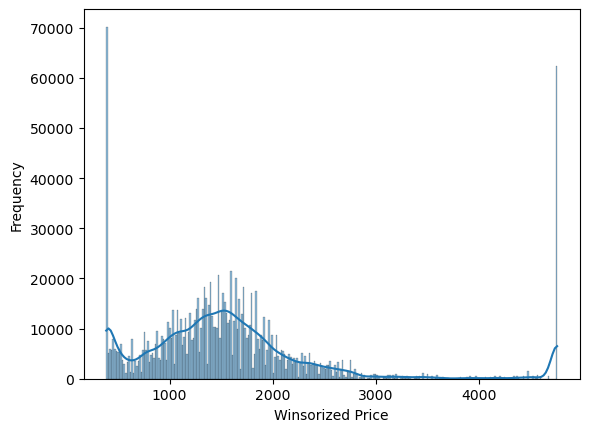

In [32]:
sns.histplot(inventories_london['pricing_winsorized'], kde=True)
plt.xlabel('Winsorized Price')
plt.ylabel('Frequency')
plt.title('Distribution of Winsorized Price\nSkewness: {:.2f}'.format(skewness))
plt.show()

#### Dropping Unnecessary Columns

In [34]:
columns_to_drop = ['source','source_link','region_type','max_sp','min_sp','max_available_price','min_available_price',
                  'owner_email','owner_phone','lease_available_from','lease_available_to',
                  'property_source_link','property_owner_email','property_owner_phone','property_bedroom_count_source2',
                  'property_lease_available_from','property_lease_available_to',
                    'latitude','longitude','country','state','district_name',    
                   'property_bedroom_count_source1','property_bathroom_count','property_area_number','property_wifi',
                   'property_pets_allowed','property_pool','property_public_transportation',
                   'property_air_condition','property_table_chair','property_dishwasher','uni_latitude','uni_longitude',
                  'latitude','longitude','property_latitude','property_longitude','public_transportation']


inventories_london.drop(columns_to_drop, axis=1, inplace=True)

/var/folders/7z/3_43hmyd44v7pjv450ysr_x80000gn/T/ipykernel_96125/2409518900.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inventories_london.drop(columns_to_drop, axis=1, inplace=True)


# feature Engineering

In [35]:
inventories_london['area_number_squared']=inventories_london['area_number']**2
inventories_london['is_near_university']=inventories_london['distance_to_uni']<2.0
#binning area number into discrete categories 
bins = [0, 50, 100, 150, np.inf]
labels = ['small', 'medium', 'large', 'extra-large']
inventories_london['area_category']=pd.cut(inventories_london['area_number'],bins=bins,labels=labels)
inventories_london['inventory_name_length']=inventories_london['inventory_name'].str.len()

#Creating interaction feature between 'bedroom_count_source2' and 'bathroom_count'
inventories_london['bed_bath_interaction']=inventories_london['bedroom_count']*inventories_london['bathroom_count']
#Changing price for better linearity 
inventories_london['log_pricing']=np.log(inventories_london['pricing'])
inventory_london_grouped = inventories_london.groupby('property_region_type')['pricing'].mean().reset_index()
inventories_london = pd.merge(inventories_london, inventory_london_grouped, on='property_region_type', suffixes=('', '_mean'))

conversion_factors_area = {
    'sqft': .092903,
    'sqm': 1
}
unit_column = 'area_unit'  # Replace 'area_unit' with the actual name of your unit column
inventories_london['property_size'] = inventories_london.apply(lambda row: row['area_number'] * conversion_factors_area.get(row[unit_column], 1), axis=1)
#Getting price from external file
price_trends=pd.read_csv('price_data.csv')
price_trends
historical_pricing = price_trends.groupby(['month_of_date', 'year_of_date'])['calculated_price'].mean().reset_index()
historical_pricing.rename(columns={'calculated_price': 'historical_price'}, inplace=True)
inventories_london_combi = pd.merge(inventories_london, historical_pricing, on=['year_of_date','month_of_date'], how='left')

# Step 3: Feature engineering
inventories_london_combi['price_difference'] = inventories_london_combi['pricing'] - inventories_london_combi['historical_price']
inventories_london_combi['price_percentage_change'] = (inventories_london_combi['pricing'] - inventories_london_combi['historical_price']) / inventories_london_combi['historical_price']
inventories_london_combi['months_since_last_update'] = (inventories_london_combi['year_of_date'].max() - inventories_london_combi['year_of_date']) * 12 + (inventories_london_combi['month_of_date'].max() - inventories_london_combi['month_of_date'])

inventories_london_combi.drop(['area_unit','area_number','id','inventory_name','ancestor_id','lease_duration',
                         'property_inventory_name','property_region_type','property_paid_duration','property_max_available_price',
                        'property_min_available_price','property_price',
                        'property_max_sp','property_payment_duration','property_min_sp','accomadation_type','paid_duration'
                        ],axis=1,inplace=True)


/var/folders/7z/3_43hmyd44v7pjv450ysr_x80000gn/T/ipykernel_96125/245986772.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inventories_london['area_number_squared']=inventories_london['area_number']**2
/var/folders/7z/3_43hmyd44v7pjv450ysr_x80000gn/T/ipykernel_96125/245986772.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inventories_london['is_near_university']=inventories_london['distance_to_uni']<2.0
/var/folders/7z/3_43hmyd44v7pjv450ysr_x80000gn/T/ipykernel_96125/245986772.py:6: SettingWithCopy

In [36]:
#Encoding the categorical variables into numerical variable
categorical_features = ['area_category','is_near_university','location_cluster','"shared_room"',
                        '"shared_kitchen"','"shared_bathroom"','"private_room"','"private_kitchen"',
                        '"private_bathroom"','"entire_place"','university_name','property_district_name',
                        'property_state','property_country','property_area_unit','property_currency','dishwasher',
                        'table_chair','air_condition','pool','pets_allowed','wifi','currency']
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
for cat_col in categorical_features:
    inventories_london_combi[cat_col]=le.fit_transform(inventories_london_combi[cat_col])
inventories_london_combi.drop('payment_duration',axis=1,inplace=True)




# Getting Correlation

In [37]:
# Split the data into features (X) and target (y)
X = inventories_london_combi.drop(['pricing'], axis=1)
y = inventories_london_combi['pricing']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
correlation_matrix = inventories_london_combi.corr()
plt.figure(figsize=(50, 30))
plt.title('Correlation Between Features')
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

/var/folders/7z/3_43hmyd44v7pjv450ysr_x80000gn/T/ipykernel_96125/2172137844.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = inventories_london_combi.corr()
